# California Housing Prices #

The California Housing Prices dataset comes from 1990 census data that was originally popularized as part of the StatsLib repository and more recently on [Kaggle](https://www.kaggle.com/camnugent/california-housing-prices). The dataset used for this course came from Kaggle but has been modified slightly to turn it into a homework assignment. The data summarizes household statistics for a single block of homes in California. It includes basic information such as the location of the block, median income levels, and median home value. We are going to use the information to predict home values.

We are going to use this dataset to learn about Multilinear Regression. Along the way we will also look at Cross Validation.

## References ##

* [Linear Regression using Python by Animesh Agarwal](https://medium.com/towards-data-science/linear-regression-using-python-b136c91bf0a2)
* [Why Use Gradient Descent for Linear Regression, When a Closed-Form Math Solution Is Available? on Stats Stack Exchange](https://stats.stackexchange.com/questions/278755/why-use-gradient-descent-for-linear-regression-when-a-closed-form-math-solution)
* [A Gentle Introduction to K-Fold Cross-Validation by Jason Brownlee](https://machinelearningmastery.com/k-fold-cross-validation/)
* [Why and How to do Cross Validation for Machine Learning by George Seif](https://towardsdatascience.com/why-and-how-to-do-cross-validation-for-machine-learning-d5bd7e60c189)
* [Cross Validation a Beginner's Guide by Caleb Neale](https://towardsdatascience.com/cross-validation-a-beginners-guide-5b8ca04962cd)

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

## Multilinear Regression ##

Multilinear Regression is a form of regression that assumes a dataset should be modeled using a linear relationship between some arbitrary number of features. It is a slightly more complicated version of Linear Regression, which assumes there is only a single feature upon which to make predictions.

### Linear Regression ###

Linear Regression is overly simple and in practice, we are unlikely to find problems that should be modeled with it. However, it does make a good example to start a classroom discussion on regression:
$$\hat{y_{i}} = \theta_{0} + \theta_{1} \cdot x_{i}$$

### Multilinear Regression ###

Multilinear Regression is simple but that's not a bad thing. Multilinear Regression can consider any arbitrary number of features and is unlikely to overfit. It is a good first choice for solving many regression problems.
$$\hat{y_{i}} = \theta_{0} + \theta_{1} \cdot x_{1}^{i} + \theta_{2} \cdot x_{2}^{i} + \cdots + \theta_{n} \cdot x_{i}^{n}$$

In [19]:
# LOAD THE DATASET

df = pd.read_csv('housing_data.csv')
df['ocean_proximity']

0        NEAR BAY
1        NEAR BAY
2        NEAR BAY
3        NEAR BAY
4        NEAR BAY
           ...   
20626      INLAND
20627      INLAND
20628      INLAND
20629      INLAND
20630      INLAND
Name: ocean_proximity, Length: 20631, dtype: object

In [20]:
# OCEAN PROXIMITY SOUNDS PROMISSING BUT IS CATEGORICAL, LET'S ENCODE IT

encoder = OneHotEncoder(handle_unknown='ignore', sparse=False) # handle_unknown='ignore' fixes issues with test data 
encoder.fit(df[['ocean_proximity']])
location = pd.DataFrame(encoder.transform(df[['ocean_proximity']]), columns=encoder.categories_[0])
location

,<1H OCEAN,INLAND,ISLAND,NEAR BAY,NEAR OCEAN
0,0.0,0.0,0.0,1.0,0.0
1,0.0,0.0,0.0,1.0,0.0
2,0.0,0.0,0.0,1.0,0.0
3,0.0,0.0,0.0,1.0,0.0
4,0.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...
20626,0.0,1.0,0.0,0.0,0.0
20627,0.0,1.0,0.0,0.0,0.0
20628,0.0,1.0,0.0,0.0,0.0
20629,0.0,1.0,0.0,0.0,0.0


In [4]:
# JOIN THE ENCODED DATA BACK TO THE ORIGINAL DATAFRAME USING BETTER NAMES

location.rename(columns={'<1H OCEAN':'loc_near_ocean', 'INLAND':'loc_inland', 'ISLAND':'loc_island', 
                         'NEAR BAY':'loc_bay', 'NEAR OCEAN':'loc_ocean'}, inplace=True)
df = pd.concat([df, location], axis=1)
df.head()

,house_id,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity,loc_near_ocean,loc_inland,loc_island,loc_bay,loc_ocean
0,1,-122.23,37.88,41,880,129.0,322,126,8.3252,452600,NEAR BAY,0.0,0.0,0.0,1.0,0.0
1,2,-122.22,37.86,21,7099,1106.0,2401,1138,8.3014,358500,NEAR BAY,0.0,0.0,0.0,1.0,0.0
2,3,-122.24,37.85,52,1467,190.0,496,177,7.2574,352100,NEAR BAY,0.0,0.0,0.0,1.0,0.0
3,4,-122.25,37.85,52,1274,235.0,558,219,5.6431,341300,NEAR BAY,0.0,0.0,0.0,1.0,0.0
4,5,-122.25,37.85,52,1627,280.0,565,259,3.8462,342200,NEAR BAY,0.0,0.0,0.0,1.0,0.0


In [5]:
# CALCULATE THE #ROOMS PER HOUSEHOLD AND #BEDROOMS PER HOUSEHOLD

df['median_rooms'] = df['total_rooms'] / df['households']
df['median_bedrooms'] = df['total_bedrooms'] / df['households']
df.head()

,house_id,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity,loc_near_ocean,loc_inland,loc_island,loc_bay,loc_ocean,median_rooms,median_bedrooms
0,1,-122.23,37.88,41,880,129.0,322,126,8.3252,452600,NEAR BAY,0.0,0.0,0.0,1.0,0.0,6.984127,1.023810
1,2,-122.22,37.86,21,7099,1106.0,2401,1138,8.3014,358500,NEAR BAY,0.0,0.0,0.0,1.0,0.0,6.238137,0.971880
2,3,-122.24,37.85,52,1467,190.0,496,177,7.2574,352100,NEAR BAY,0.0,0.0,0.0,1.0,0.0,8.288136,1.073446
3,4,-122.25,37.85,52,1274,235.0,558,219,5.6431,341300,NEAR BAY,0.0,0.0,0.0,1.0,0.0,5.817352,1.073059
4,5,-122.25,37.85,52,1627,280.0,565,259,3.8462,342200,NEAR BAY,0.0,0.0,0.0,1.0,0.0,6.281853,1.081081


In [6]:
# REMOVE COLUMNS THAT ARE OBVIOUSLY USELESS

df = df[['median_house_value', 'longitude', 'latitude', 'housing_median_age', 'population', 'median_bedrooms', 
         'median_rooms', 'median_income', 'loc_near_ocean', 'loc_inland', 'loc_island', 'loc_bay', 'loc_ocean']]
df.head()

,median_house_value,longitude,latitude,housing_median_age,population,median_bedrooms,median_rooms,median_income,loc_near_ocean,loc_inland,loc_island,loc_bay,loc_ocean
0,452600,-122.23,37.88,41,322,1.023810,6.984127,8.3252,0.0,0.0,0.0,1.0,0.0
1,358500,-122.22,37.86,21,2401,0.971880,6.238137,8.3014,0.0,0.0,0.0,1.0,0.0
2,352100,-122.24,37.85,52,496,1.073446,8.288136,7.2574,0.0,0.0,0.0,1.0,0.0
3,341300,-122.25,37.85,52,558,1.073059,5.817352,5.6431,0.0,0.0,0.0,1.0,0.0
4,342200,-122.25,37.85,52,565,1.081081,6.281853,3.8462,0.0,0.0,0.0,1.0,0.0


In [7]:
# EARLIER WE NOTICED THAT THERE SEEMED TO BE A MAXIMUM HOUSE VALUE

df['median_house_value'].max()

500001

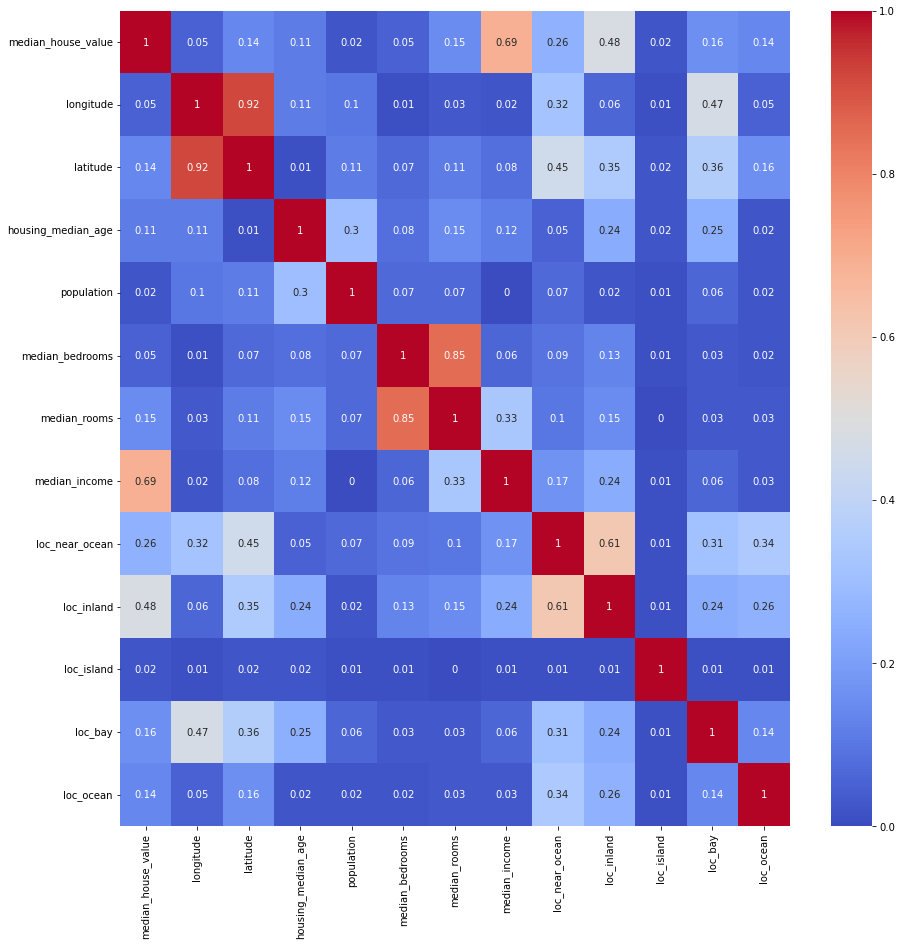

In [8]:
# FIND OUT WHICH VARIABLES ARE LIKELY THE MOST IMPORTANT

corr_matrix = df.corr().round(2).abs()
plt.figure(figsize=(15,15))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.show()

In [9]:
# CREATE A LINEAR MODEL AND TEST IT OUT

df = df[['median_house_value', 'latitude', 'median_rooms', 'median_income', 
         'loc_near_ocean', 'loc_inland', 'loc_ocean', 'loc_bay']]
X = df.iloc[:,1:]
y = pd.DataFrame(df.iloc[:,0])

X_train, X_test, y_train, y_test = train_test_split(X, y)

model = LinearRegression()
model.fit(X_train, y_train)
y_pred = pd.DataFrame(model.predict(X_test), columns=['median_house_value'])

r2_score(y_test, y_pred)

0.5853779094795919

## Cross Validation ##

If you've ever trained a machine learning model multiple times in a row using train/test splits, you'll notice that the performance of the model changes each time. Sometimes the score is a bit higher and other times its a bit lower. The score depends greatly on which data is chosen for training and which data is chosen for testing. It's possible--even likely--that the specific choice of training data introduces bias that overfits your model. This is especially common if the overall dataset is small.

You might be thinking that the train/test split was chosen at random and therefore it couldn't be introducing a bias. But what happens if the random split just happens to select training values that produce slightly 'higher' results, leaving test values that produce slightly 'lower' results. Such a split would influence your model for the worse. One possible solution would be to find a new split that is more balanced and representative of the overall dataset. But how do you know where this split is? A better solution would be to try multiple train/test splits and to evaluate their overall scores.

Cross Validation is a technique to automatically choose multiple train/test splits, training the model anew for each split. The overall score will be the mean performance metric and other statistics such as standard variation can also help to evaluate the model (lower standard deviation values are better). Scikit Learn provides cross validation with the KFold object. There are multiple ways to use KFold, as described in the reference articles above. Here is one such example:

In [10]:
# TRY ALL FEATURES THAT CORRELATION MATRIX SCORED HIGHER THAN 0.10

df2 = df[['median_house_value', 'latitude', 'median_rooms', 'median_income', 
         'loc_near_ocean', 'loc_inland', 'loc_ocean', 'loc_bay']]
X = df2.iloc[:,1:]
y = pd.DataFrame(df2.iloc[:,0])

cv = KFold(n_splits=10, shuffle=True)
model = LinearRegression()
scores = cross_val_score(model, X, y, scoring='r2', cv=cv, n_jobs=-1)
print(f'R2 Accuracy: {round(np.mean(scores),3)} {round(np.std(scores),3)}')

R2 Accuracy: 0.587 0.012


In [11]:
# REMOVE LATITUDE

df2 = df[['median_house_value', 'median_rooms', 'median_income', 
         'loc_near_ocean', 'loc_inland', 'loc_ocean', 'loc_bay']]
X = df2.iloc[:,1:]
y = pd.DataFrame(df2.iloc[:,0])

cv = KFold(n_splits=10, shuffle=True)
model = LinearRegression()
scores = cross_val_score(model, X, y, scoring='r2', cv=cv, n_jobs=-1)
print(f'R2 Accuracy: {round(np.mean(scores),3)} {round(np.std(scores),3)}')

R2 Accuracy: 0.587 0.013


In [12]:
# REMOVE MEDIAN_ROOMS

df2 = df[['median_house_value', 'median_income', 'loc_near_ocean', 'loc_inland', 'loc_ocean', 'loc_bay']]
X = df2.iloc[:,1:]
y = pd.DataFrame(df2.iloc[:,0])

cv = KFold(n_splits=10, shuffle=True)
model = LinearRegression()
scores = cross_val_score(model, X, y, scoring='r2', cv=cv, n_jobs=-1)
print(f'R2 Accuracy: {round(np.mean(scores),3)} {round(np.std(scores),3)}')

R2 Accuracy: 0.587 0.014


In [13]:
# REMOVE LOC_OCEAN AND LOC_BAY

df2 = df[['median_house_value', 'median_income', 'loc_near_ocean', 'loc_inland']]
X = df2.iloc[:,1:]
y = pd.DataFrame(df2.iloc[:,0])

cv = KFold(n_splits=10, shuffle=True)
model = LinearRegression()
scores = cross_val_score(model, X, y, scoring='r2', cv=cv, n_jobs=-1)
print(f'R2 Accuracy: {round(np.mean(scores),3)} {round(np.std(scores),3)}')

R2 Accuracy: 0.587 0.013


## Train Model Using Best Features ##

After evaluating the cross validated models, we decide to use one particular set of features with a particular encoding scheme.

In [14]:
df = pd.read_csv('housing_data.csv')

encoder = OneHotEncoder(handle_unknown='ignore', sparse=False)
encoder.fit(df[['ocean_proximity']])
location = pd.DataFrame(encoder.transform(df[['ocean_proximity']]), columns=encoder.categories_[0])
location.rename(columns={'<1H OCEAN':'loc_near_ocean', 'INLAND':'loc_inland', 'ISLAND':'loc_island', 
                         'NEAR BAY':'loc_bay', 'NEAR OCEAN':'loc_ocean'}, inplace=True)
df = pd.concat([df, location], axis=1)

df['median_rooms'] = df['total_rooms'] / df['households']
df['median_bedrooms'] = df['total_bedrooms'] / df['households']
df = df[['median_house_value', 'longitude', 'latitude', 'housing_median_age', 'population', 'median_bedrooms', 
         'median_rooms', 'median_income', 'loc_near_ocean', 'loc_inland', 'loc_island', 'loc_bay', 'loc_ocean']]

# USE FEATURES THAT RECEIVED BEST CROSS VALIDATION SCORE
df = df[['median_house_value', 'median_income', 'loc_near_ocean', 'loc_inland', 'loc_ocean', 'loc_bay']]
X = df.iloc[:,1:]
y = pd.DataFrame(df2.iloc[:,0])

model = LinearRegression()
model.fit(X, y)

LinearRegression()

## Make Predictions Using Model ##

With our trained model, it's time to make some real predictions.

In [15]:
df = pd.read_csv('housing_test.csv')

encoder.transform(df[['ocean_proximity']])
location = pd.DataFrame(encoder.transform(df[['ocean_proximity']]), columns=encoder.categories_[0])
location.rename(columns={'<1H OCEAN':'loc_near_ocean', 'INLAND':'loc_inland', 'ISLAND':'loc_island', 
                         'NEAR BAY':'loc_bay', 'NEAR OCEAN':'loc_ocean'}, inplace=True)
df = pd.concat([df, location], axis=1)
df['median_rooms'] = df['total_rooms'] / df['households']
df['median_bedrooms'] = df['total_bedrooms'] / df['households']
df = df[['house_id', 'longitude', 'latitude', 'housing_median_age', 'population', 'median_bedrooms', 'median_rooms', 
         'median_income', 'loc_near_ocean', 'loc_inland', 'loc_island', 'loc_bay', 'loc_ocean']]

# USE SAME FATURES AS TRAINING SET EXCEPT WE DON'T HAVE ANY TEST DATA
X = df[['median_income', 'loc_near_ocean', 'loc_inland', 'loc_ocean', 'loc_bay']]
y_pred = pd.DataFrame(model.predict(X), columns=['median_house_value'])
y_pred.loc[y_pred['median_house_value'] > 500000, 'median_house_value'] = 500001
y_pred['median_house_value'] = round(y_pred['median_house_value'], 0).astype(np.uint)
y_pred['house_id'] = df['house_id']
y_pred = y_pred[['house_id', 'median_house_value']]
y_pred

,house_id,median_house_value
0,7,239999
1,2021,55227
2,5956,132276
3,5957,210149
4,7820,273868
5,8877,500001
6,11950,150836
7,15734,194090
8,15747,213983


## Save Results to CSV File ##

In [16]:
y_pred.to_csv('housing_results.csv', index=False)

## Grade the Results ##

You won't have the answers to these housing units, but the last step for me is to grade your results... like this:

In [17]:
y_test = pd.read_csv('housing_results.csv')
y_test.rename(columns={'median_house_value':'actual_value'}, inplace=True)
y_test

,house_id,actual_value
0,7,239999
1,2021,55227
2,5956,132276
3,5957,210149
4,7820,273868
5,8877,500001
6,11950,150836
7,15734,194090
8,15747,213983


In [18]:
print(r2_score(y_test, y_pred))
results = pd.merge(y_test, y_pred, on='house_id')
results.rename(columns={'median_house_value':'predicted_value'}, inplace=True)
results['accuracy'] = round(100 * results['predicted_value'] / results['actual_value'], 1)
results

1.0


,house_id,actual_value,predicted_value,accuracy
0,7,239999,239999,100.0
1,2021,55227,55227,100.0
2,5956,132276,132276,100.0
3,5957,210149,210149,100.0
4,7820,273868,273868,100.0
5,8877,500001,500001,100.0
6,11950,150836,150836,100.0
7,15734,194090,194090,100.0
8,15747,213983,213983,100.0
